In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as ra

In [2]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [6]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [7]:
file_pth = 'binary_ffn_all.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained


<All keys matched successfully>

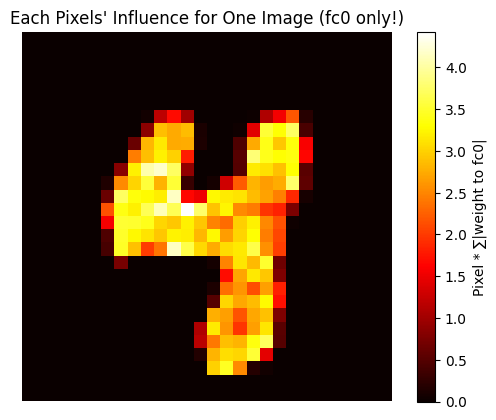

In [8]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze() #[28, 28]

weights = net.fc0.weight.detach().cpu() #[32, 784]
importance = weights.abs().sum(dim=0).view(28, 28) #[28, 28]

activation_fc0 = img * importance #[28, 28] 

plt.imshow(activation_fc0, cmap='hot', vmin=0, vmax=activation_fc0.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title("Each Pixels' Influence for One Image (fc0 only!)")
plt.axis('off')
plt.show()

In [9]:
#shows that often most areas of the digit are important (in fc0, not at final decision), but if less is needed for a correct prediciton, weights do distribute accordingly

0: 16.731155395507812
1: 5.901057243347168
2: 2.8543896675109863
3: 8.077707290649414
4: 4.243329048156738
5: 6.387068271636963
6: 11.36577033996582
7: 22.649892807006836
8: 20.467683792114258
9: 7.000221252441406
10: 4.096213340759277
11: 21.814044952392578
12: 3.2110323905944824
13: 0.3688794672489166
14: 2.5615062713623047
15: 1.873213768005371
16: 0.7353917360305786
17: 1.8337687253952026
18: 5.111143589019775
19: 1.3168423175811768
20: 14.718544006347656
21: 9.538851737976074
22: 1.461020588874817
23: 3.7361130714416504
24: 0.0
25: 16.165176391601562
26: 0.0
27: 8.710107803344727
28: 8.015713691711426
29: 0.0
30: 9.878193855285645
31: 0.3976157009601593
torch.Size([32])


/tmp/ipykernel_23339/1238684222.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


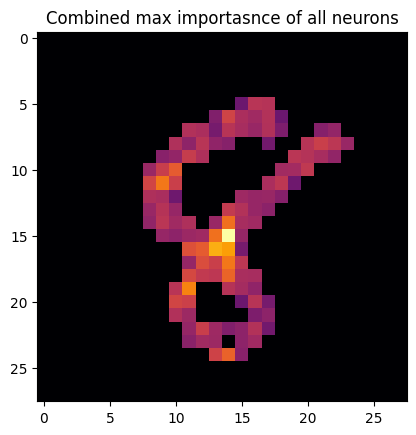

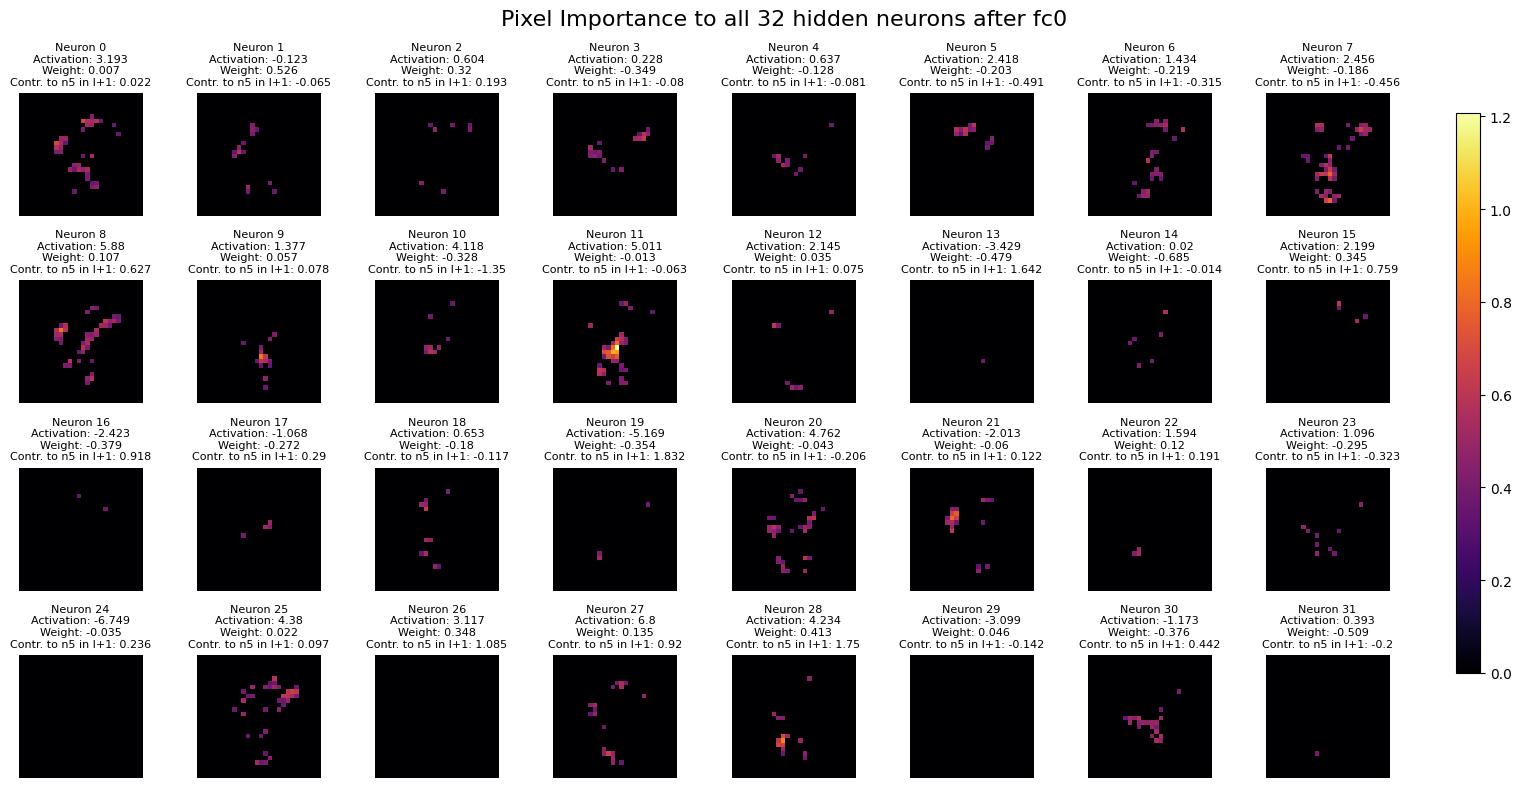

In [10]:

inputs, labels = next(iter(test_loader))
dig_to_check = 8

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break
    
#img = torch.full((28, 28), 255).float()

plt.imshow(img, cmap="inferno")
#plt.title(f"Predicted by net: {pred}")

img_flat = img.view(-1)

weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #32, 784

#mask = (img_flat > 0).float()
#contribs = contribs * mask

#contribs = torch.clamp(contribs, min=0.0)

#normalise to [0, 1]
max_val = contribs.max()
contribs_norm = contribs / max_val
contribs_imgs = contribs_norm.view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    1
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #no bias where background = 0

contribs_imgs = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.where(
        contribs_imgs > 0.35,
        contribs_imgs,
        torch.tensor(0.0, device=contribs_imgs.device)
    )
)

activation_modified = []
for i, mat in enumerate(contribs_imgs):
    mat = mat.sum().item()
    print(f"{i}: {mat}")
    activation_modified.append(mat)


#combo = contribs_imgs.sum(dim=0)
combo = contribs_imgs.max(dim=0).values

#normalise
#max_val = combo.max()
#combo /= max_val

"""combo = torch.where(
    combo == 0,
    torch.tensor(0.0, device=combo.device),
    torch.where(
        combo > 0.35,
        combo,
        torch.tensor(0.1, device=combo.device)
    )
)"""



"""for i, mat in enumerate(contribs_imgs):
    if i == 0:
        activations = mat.sum(dim=0)
        continue

    activations += mat.sum(dim=0)"""
#instead take actualy activaiton, this is modified for visuals!
activations = net.fc0(img.view(1, -1).cuda()).squeeze()

next_neuron_idx = 5

weights_to_neuron = net.fc1.weight[next_neuron_idx]
contribution = activations * weights_to_neuron
#next_contribs = contribution.sum(dim=1) #dim = 1 means y-axis, so all weights to neuron

#print(next_contribs.size())
print(weights_to_neuron.size())

plt.imshow(combo, cmap="inferno")
plt.title("Combined max importasnce of all neurons")

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    im = ax.imshow(contribs_imgs[i], cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nWeight: {round(weights_to_neuron[i].item(), 3)}\nContr. to n{next_neuron_idx} in l+1: {round(contribution[i].item(), 3)}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [11]:
#activation function can be ignored, as it is ReLU and this image is normalise by setting negative value to 0 already!

In [12]:
#!NOTE TO SELF: ONCE DONE, REMOVE CERTAIN PATCHES FOR DECISIONS, TO SHOW THAT THIS PART WAS IMPORTANCE, AND USE EXAMPLE OF E.G., 3 VS 8 WHICH SHOULD BECOME HARDER THEN

In [13]:
#next steps planned for thu: segmenter for relevant patches, make class cinstruction for concepts, make indexing system to trace activations through FFN, start summariser system to reduce FFN, check FFN accuracy with reduced paths

In [14]:
"""import torch
import matplotlib.pyplot as plt

#Parameters
imgs = [x.clamp(0, 1) for x in contribs_imgs]
value_thresh = 0.9
loc_thresh = 3
groups = []
used = set()



for g_idx, group in enumerate(groups):
    plt.figure(figsize=(len(group)*2, 2))
    for idx, img_idx in enumerate(group):
        plt.subplot(1, len(group), idx + 1)
        plt.imshow(imgs[img_idx].squeeze(), cmap='inferno', vmin=0, vmax=1)
        plt.axis('off')
    plt.suptitle(f'Group {g_idx+1}')
    plt.tight_layout()
    plt.show()
"""
#for now leave away similarity clustering, maybe better after recombination

"import torch\nimport matplotlib.pyplot as plt\n\n#Parameters\nimgs = [x.clamp(0, 1) for x in contribs_imgs]\nvalue_thresh = 0.9\nloc_thresh = 3\ngroups = []\nused = set()\n\n\n\nfor g_idx, group in enumerate(groups):\n    plt.figure(figsize=(len(group)*2, 2))\n    for idx, img_idx in enumerate(group):\n        plt.subplot(1, len(group), idx + 1)\n        plt.imshow(imgs[img_idx].squeeze(), cmap='inferno', vmin=0, vmax=1)\n        plt.axis('off')\n    plt.suptitle(f'Group {g_idx+1}')\n    plt.tight_layout()\n    plt.show()\n"

In [15]:
#recombine in next layer l+1

In [16]:
weights_fc1 = net.fc1.weight.detach().cpu()
concepts = contribs_imgs

In [17]:
weights_exp = weights_fc1.unsqueeze(-1).unsqueeze(-1)
concepts_exp = concepts.unsqueeze(0)
combined = (weights_exp * concepts_exp).sum(dim=1)

In [18]:
#normalise to [0, 1]
max_val = combined.max()
combined = combined / max_val
#combined = combined.view(-1, 28, 28)

biases_fc1 = net.fc1.bias.detach().cpu()
combined += biases_fc1[:, None, None]

combined = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.where(
        combined > 0.35,
        combined,
        torch.tensor(0.1, device=combined.device)
    ) 
)

In [19]:
weights_fc2 = net.fc2.weight.detach().cpu()

In [20]:
import torch.nn.functional as F
import math

In [23]:
with torch.no_grad():
    x = img.view(1, -1).cuda()
    a0 = F.tanh(net.fc0(x)) #using tanh because ReLU bad for explainability, issue because -a*(-w) = z > 0, but becomes 0 due to ReLU
    a1 = F.tanh(net.fc1(a0)) #would have been positive activation and useful to explanaiton
    logits_fc2 = net.fc2(a1)

print(a1.size())
print(f"out: {logits_fc2}")


torch.Size([1, 16])
out: tensor([[-1.1994, -1.5481,  2.0894,  0.4341, -2.9513, -1.7800, -2.1143, -0.7994,
          1.3523, -1.9005]], device='cuda:0')


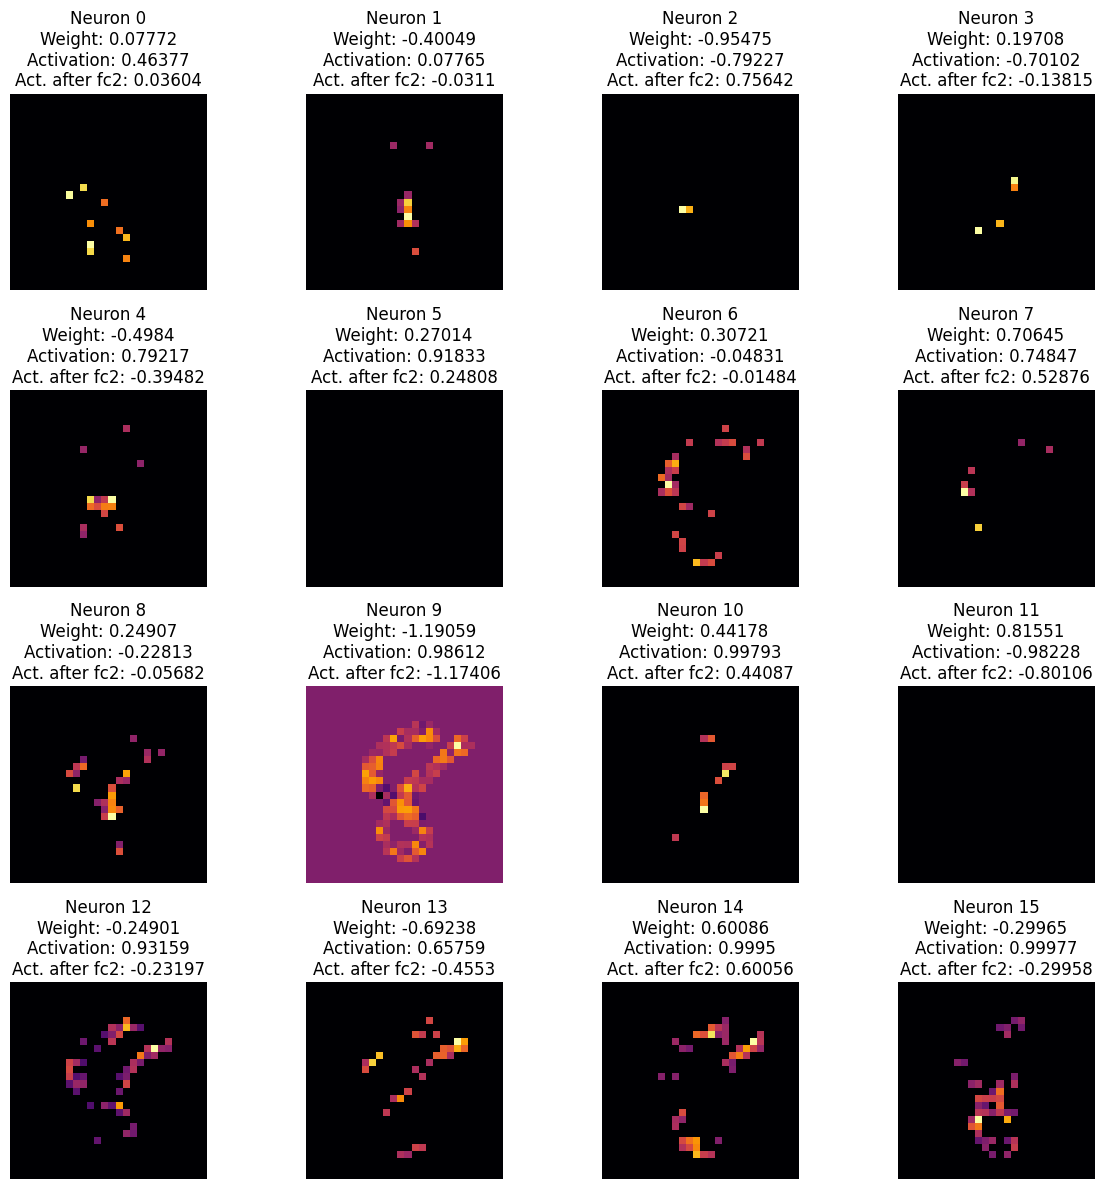

tensor([-0.2125,  0.2545,  0.2848, -0.1848, -0.1336, -0.1580, -0.0627,  0.1076,
        -0.0926, -0.0174])


In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):  
    ax.imshow(combined[idx].cpu(), cmap='inferno')
    ax.axis('off')
    ax.set_title(f'Neuron {idx}\nWeight: {round(weights_fc2[0][idx].item(), 5)}\nActivation: {round(a1[0][idx].item(), 5)}\nAct. after fc2: {round(weights_fc2[0][idx].item() * a1[0][idx].item(), 5)}')
plt.tight_layout()
plt.show()

bias_fc2 = net.fc2.bias.detach().cpu()
print(bias_fc2)

#concepts after fc1

In [ ]:
#Important Note, I learned:
#A trait of a digit may contribute negatively to decision that it is that digit, and only in last layer flip sign to contribute positively, due to both negative weight and activation!
#clearly seen here!

#(unless using ReLU)

########################
#concepts for the trained digits have positive contribution, other negative, in principle teh net checks for the presence of these concepts

Idea: Trace back concepts from fc2 to fc1 and then label the importance of a concept (not just pixel values) in the input image, with a section color for clear conceptual and segmented explanation

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        mask = (labels != -1)
        if not mask.any():
            continue
        images = images[mask]
        if CUDA:
            images = images.cuda()
        images = images.view(-1, 28*28)

        a0 = F.tanh(net.fc0(images))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)
        predicted = (torch.sigmoid(logits) >= 0.5).float()

        correct += predicted.sum().item()
        total += images.size(0)

    print(f'Accuracy on digit {"trained_dig"} (manual pass with activations): {100 * correct / total:.2f} %')

#wtf is this accuracy??

Accuracy on digit trained_dig (manual pass with activations): 527.54 %


In [ ]:
#note: before adjusting dataset not to be biased to many more non-bin_digit's in proportion, using ReLU was needed, 
#because it would make negative contributions that were only <0 because the net was biased, trained on uneven data, but now that the dataset is fixed,
#ReLU is hurting the explainability and tanh or even no activation function at all is giving higher accuracy!

Text(0.5, 1.0, 'most important 50% of pixels')

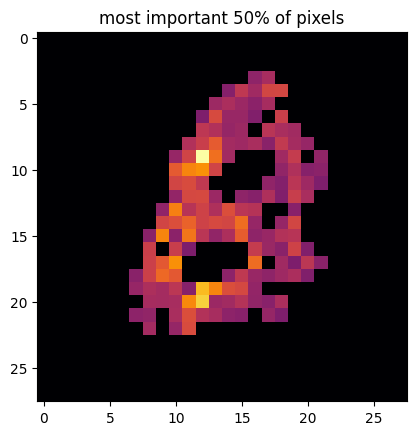

In [ ]:
#input segmentation with importance, influence, color attribution in plot for clear overview, after that: implement recreation with new algorithm

combo = torch.where(
        combo > 0.0,
        combo,
        torch.tensor(0.0, device=combined.device)
    )

plt.imshow(combo, cmap="inferno")
plt.title("most important 50% of pixels")

#-> segment this

In [ ]:
pixel_count = combo.view(-1).size()[0]
pixel_count_important = (combo > 0).sum().item()
segment_size = round(pixel_count_important * 0.075, 0)
pixel_count_important, segment_size

(161, 12.0)

In [ ]:
imp_pixels = (combo > 0).nonzero(as_tuple=False) #tensor of coordiantes that aren't = 0

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

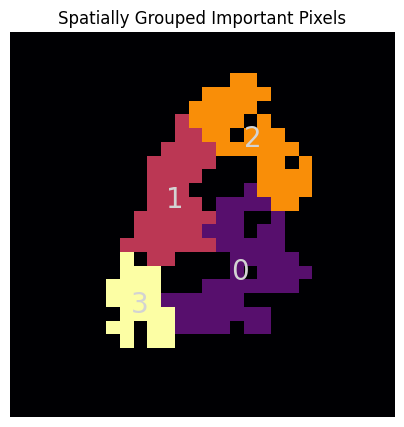

In [ ]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=segment_size,
    linkage='complete',
    metric='euclidean'
)
labels = clusterer.fit_predict(imp_pixels)

clusters = defaultdict(list)
for coord, label in zip(imp_pixels, labels):
    clusters[label].append(coord)

#making a map
label_map = torch.zeros((28, 28), dtype=torch.int32)
for label, coords in clusters.items():
    for y, x in coords:
        label_map[y, x] = label + 1

label_map_np = label_map.numpy()
unique_vals = np.unique(label_map_np)

plt.figure(figsize=(5, 5))
plt.imshow(label_map_np, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Spatially Grouped Important Pixels')

for val in unique_vals:
    positions = np.argwhere(label_map_np == val)
    if positions.size == 0 or val == 0:
        continue
    centroid = positions.mean(axis=0)
    y, x = centroid
    plt.text(x, y, str(val-1), color='lightgray', fontsize=20, ha='center', va='center')

plt.show()


In [ ]:
label_neuron_dict = {}

for label in set(labels):
    label_neuron_dict[label] = {}

for coord, label in zip(imp_pixels, labels):
    y, x = coord
    for idx, neuron_map in enumerate(contribs_imgs):
        val = neuron_map[y, x]
        if val > 0.6:
            label_neuron_dict[label][idx] = label_neuron_dict[label].get(idx, 0) + val


sorted_label_neuron = {
  label: sorted(neurons.items(), key=lambda item: item[1], reverse=True)
  for label, neurons in label_neuron_dict.items()
}
sorted_label_neuron

{0: [(26, tensor(2.5013)),
  (10, tensor(0.6948)),
  (7, tensor(0.6866)),
  (2, tensor(0.6824)),
  (24, tensor(0.6437)),
  (14, tensor(0.6323)),
  (0, tensor(0.6000))],
 1: [(24, tensor(2.3465)),
  (3, tensor(1.5106)),
  (19, tensor(1.3674)),
  (15, tensor(1.3317)),
  (4, tensor(0.7438)),
  (31, tensor(0.6739)),
  (13, tensor(0.6470)),
  (20, tensor(0.6388)),
  (30, tensor(0.6352)),
  (6, tensor(0.6343))],
 2: [],
 3: [(10, tensor(2.8231)), (20, tensor(0.6315)), (26, tensor(0.6192))]}

In [ ]:
def meshgrid(size):
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
    return x, y

def circle(size, radius, angle_range, center, thickness):
    x, y = meshgrid(size)
    dx = x - center[0]
    dy = y - center[1]
    dist = torch.sqrt(dx**2 + dy**2)
    angles = torch.atan2(dy, dx) * 180 / torch.pi % 360
    angle_min, angle_max = angle_range
    angle_mask = (angles >= angle_min) & (angles <= angle_max) if angle_min < angle_max else \
                 (angles >= angle_min) | (angles <= angle_max)
    circle_mask = ((dist >= radius - thickness / 2) & (dist <= radius + thickness / 2)) & angle_mask
    return circle_mask.float()

def line(size, length, angle, center, thickness):
    x, y = meshgrid(size)
    angle_rad = torch.tensor(angle) * torch.pi / 180
    dx = torch.cos(angle_rad)
    dy = torch.sin(angle_rad)
    x0 = center[0] - dx * length / 2
    y0 = center[1] - dy * length / 2
    x1 = center[0] + dx * length / 2
    y1 = center[1] + dy * length / 2
    px = x - x0
    py = y - y0
    proj = (px * dx + py * dy).clamp(0, length)
    closest_x = x0 + proj * dx
    closest_y = y0 + proj * dy
    dist = torch.sqrt((x - closest_x) ** 2 + (y - closest_y) ** 2)
    return (dist <= thickness / 2).float()

"""def cross(size, length, angle, center, thickness):
    l1 = line(size, length, angle, center, thickness)
    l2 = line(size, length, angle + 90, center, thickness)
    return (l1 + l2).clamp(0, 1)"""



'def cross(size, length, angle, center, thickness):\n    l1 = line(size, length, angle, center, thickness)\n    l2 = line(size, length, angle + 90, center, thickness)\n    return (l1 + l2).clamp(0, 1)'

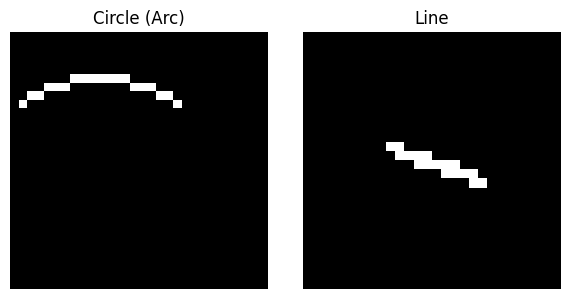

In [ ]:
import matplotlib.pyplot as plt

#Create the concept tensors
C = circle(size=30, radius=15, angle_range=(230, 310), center=(10, 20), thickness=1.0)
L = line(size=28, length=10, angle=20, center=(14, 14), thickness=1.5)
#X = cross(size=28, length=18, angle=130, center=(14, 10), thickness=1.5)

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(C, cmap='gray')
axs[0].set_title('Circle (Arc)')
axs[1].imshow(L, cmap='gray')
axs[1].set_title('Line')
#axs[2].imshow(X, cmap='gray')
#axs[2].set_title('Cross')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


########
#circle still a bit  in accurate, bad for relation testing


In [ ]:
#now apply to activated parts of input to represent it with these concepts, do that for many input
#then for each input example find relation rules and based on all data the limits
#apply these limit rules to predict digit without FFN

In [ ]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import random as ra

In [ ]:
#this code cell is only for segmentation and not my personal code

def neighbors_8(img, y, x):
    h, w = img.shape
    for ny in range(max(y-1,0), min(y+2,h)):
        for nx in range(max(x-1,0), min(x+2,w)):
            if (ny, nx) != (y, x):
                yield ny, nx

def find_primary_continuous_path(skeleton_image):
    if not np.any(skeleton_image):
        return []

    active_pixels = set(zip(*np.where(skeleton_image)))
    if not active_pixels:
        return []

    start_point = None
    for r, c in active_pixels:
        count = sum(1 for nr, nc in neighbors_8(skeleton_image, r, c) if skeleton_image[nr, nc])
        if count <= 1:
            start_point = (r, c)
            break
    if not start_point:
        start_point = next(iter(active_pixels))
        
    path = []
    visited = set()
    stack = [start_point]

    while stack:
        current_pixel = stack.pop()
        
        if current_pixel in visited:
            continue
        
        visited.add(current_pixel)
        path.append(current_pixel)

        unvisited_neighbors = []
        for ny, nx in neighbors_8(skeleton_image, *current_pixel):
            if skeleton_image[ny, nx] and (ny, nx) not in visited:
                unvisited_neighbors.append((ny, nx))
        
        for neighbor in unvisited_neighbors:
            stack.append(neighbor)

    return path

def bresenham_line(y0, x0, y1, x1):
    points = []
    dy = abs(y1 - y0)
    dx = abs(x1 - x0)
    sy = 1 if y0 < y1 else -1
    sx = 1 if x0 < x1 else -1
    err = dx - dy
    while True:
        points.append((y0, x0))
        if y0 == y1 and x0 == x1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def segment_only_on_white_pixels(start, end, skeleton):
    points_on_line = bresenham_line(start[0], start[1], end[0], end[1])
    return all(skeleton[y, x] != 0 for y, x in points_on_line)

def line_approximation_with_corners(path, angle_tolerance_degrees=20):
    segments = []
    if len(path) < 2:
        return segments

    current_segment_start_point = path[0]

    for i in range(1, len(path)):
        current_point_on_path = path[i]

        if i == len(path) - 1:
            if segment_only_on_white_pixels(current_segment_start_point, current_point_on_path, skeleton):
                segments.append((current_segment_start_point, current_point_on_path))
            break

        next_point_on_path = path[i + 1]

        v1 = np.array(current_point_on_path) - np.array(current_segment_start_point)
        v2 = np.array(next_point_on_path) - np.array(current_point_on_path)

        if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
            continue

        dot_product = np.dot(v1, v2)
        magnitude_v1 = np.linalg.norm(v1)
        magnitude_v2 = np.linalg.norm(v2)

        cos_theta = max(-1.0, min(1.0, dot_product / (magnitude_v1 * magnitude_v2)))

        angle_radians = math.acos(cos_theta)
        angle_degrees = math.degrees(angle_radians)

        is_corner = (angle_degrees > angle_tolerance_degrees and
                     angle_degrees < (180 - angle_tolerance_degrees))

        if is_corner or not segment_only_on_white_pixels(current_segment_start_point, current_point_on_path, skeleton):
            if segment_only_on_white_pixels(current_segment_start_point, current_point_on_path, skeleton):
                segments.append((current_segment_start_point, current_point_on_path))
            current_segment_start_point = current_point_on_path

    if current_segment_start_point != path[-1] or not segments:
        if len(path) > 1 and (not segments or segments[-1][1] != path[-1]):
            if segment_only_on_white_pixels(current_segment_start_point, path[-1], skeleton):
                segments.append((current_segment_start_point, path[-1]))

    return segments

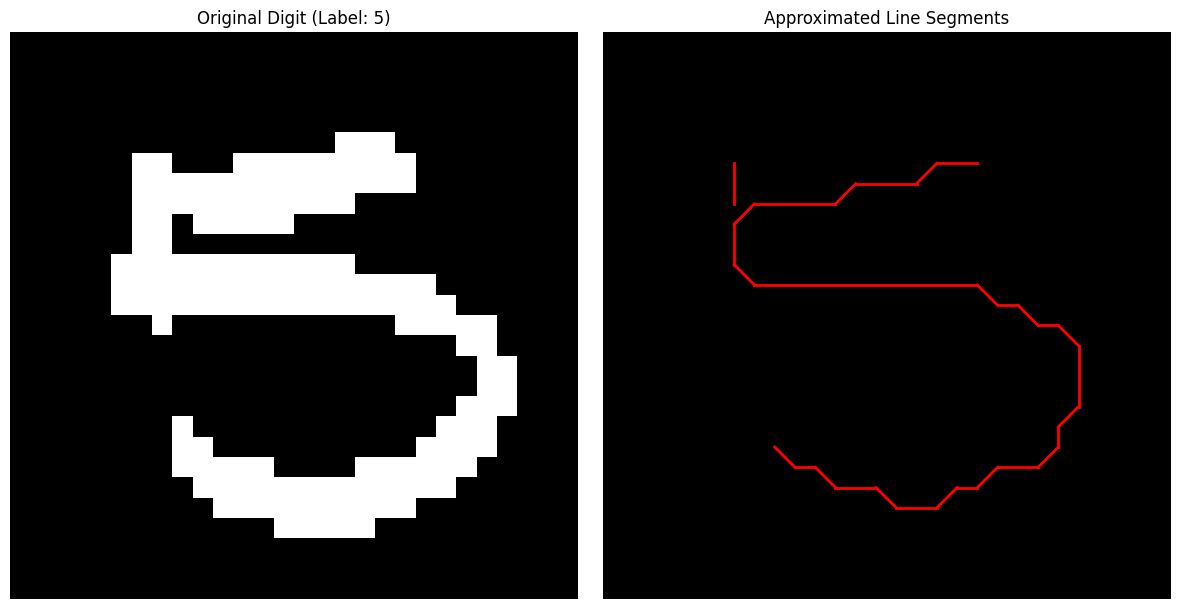

array([[ 6., 18.],
       [ 6., 16.],
       [ 6., 16.],
       [ 7., 15.],
       [ 7., 15.],
       [ 7., 12.],
       [ 7., 12.],
       [ 8., 11.],
       [ 8., 11.],
       [ 8.,  7.],
       [ 8.,  7.],
       [ 9.,  6.],
       [ 9.,  6.],
       [11.,  6.],
       [11.,  6.],
       [12.,  7.],
       [12.,  7.],
       [12., 18.],
       [12., 18.],
       [13., 19.],
       [13., 19.],
       [13., 20.],
       [13., 20.],
       [14., 21.],
       [14., 21.],
       [14., 22.],
       [14., 22.],
       [15., 23.],
       [15., 23.],
       [18., 23.],
       [18., 23.],
       [19., 22.],
       [19., 22.],
       [20., 22.],
       [20., 22.],
       [21., 21.],
       [21., 21.],
       [21., 19.],
       [21., 19.],
       [22., 18.],
       [22., 18.],
       [22., 17.],
       [22., 17.],
       [23., 16.],
       [23., 16.],
       [23., 14.],
       [23., 14.],
       [22., 13.],
       [22., 13.],
       [22., 11.],
       [22., 11.],
       [21., 10.],
       [21.,

In [ ]:
#data prep
inputs, labels = next(iter(train_loader))
dig_to_check = 5
while True:
    ind = ra.randrange(len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break

img = torch.where(img > img.max()*0.3, 255, 0).to(torch.uint8)
inp = img.cpu().numpy()

#segmnetation
skeleton = skeletonize(inp // 255).astype(np.uint8)
continuous_pixel_path = find_primary_continuous_path(skeleton)
line_segments = line_approximation_with_corners(continuous_pixel_path, angle_tolerance_degrees=20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(inp, cmap='gray')
plt.title(f'Original Digit (Label: {dig_to_check})')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.zeros_like(inp), cmap='gray') 
plt.title('Approximated Line Segments')

concept_coords = np.empty((0, 2))

for start_p, end_p in line_segments:
    plt.plot([start_p[1], end_p[1]], [start_p[0], end_p[0]], 'r-', linewidth=2)
    concept_coords = np.append(concept_coords, np.array([start_p, end_p]), axis=0)
plt.axis('off')

plt.tight_layout()
plt.show()

concept_coords

In [ ]:
#next: teach algo to recognize concepts so it can test their relations for classification